# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [2]:
# dataDir = "/home/ababil/BUET/AV/csv"
dataDir = "D:/AV/Code/location-2"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [3]:
exec(open('init_notebook.py').read())

current working dirD:\AV\Code\behavior-hypotheses\src


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from behavior_tools.TrajectoryADECalculator import TrajectoryADECalculator
from behavior_tools.Sampler import Sampler
from tti_dataset_tools.ColMapper import ColMapper

from behavior_tools.Testing import TrajectoryTestingCalculator

In [6]:
sceneId = 210
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

In [7]:
visualizer = TrajectoryVisualizer()
adeCalculator = TrajectoryADECalculator()

testingCalculator = TrajectoryTestingCalculator()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity',
        xAccCol='sceneXAcceleration',
        yAccCol='sceneYAcceleration',
        speedCol='speed',
        accelerationCol='acceleration',
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minAcceleration = 0.0,
    maxAcceleration = 2.0,   
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
transformer.deriveAcceleration(pedDf)
# plt.boxplot(pedDf['displacementY'])
# plt.show()
# plt.boxplot(pedDf['speed'])
# plt.show()
# plt.boxplot(pedDf['acceleration'])
# plt.show()

In [8]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (5)


7600

In [9]:

startingDf = cleanPedDf[cleanPedDf["displacementY"] < 1].copy()
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()
startingDf.head(10)

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489


In [10]:
# plt.boxplot(startingDf["speed"])

In [11]:
# get the pedestrians who started at almost 0 speed.
# get pedestrians who started at almost the median speed.
medianStartingSpeed = startingDf["speed"].median()
medianStartingVelocityDf = startingDf[abs(startingDf["speed"] - medianStartingSpeed) < 0.005].copy()
medianStartingVelocityPedIds = list(medianStartingVelocityDf["uniqueTrackId"].unique())
# medianStartingVelocityPedIds

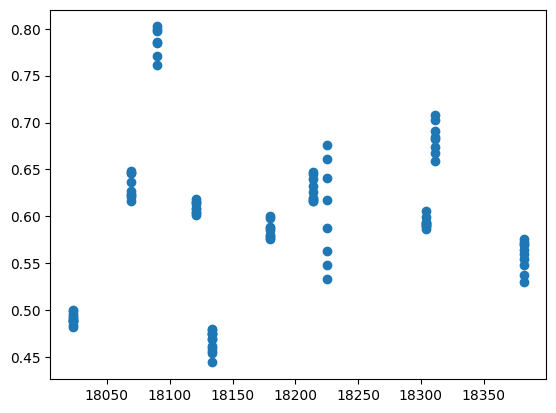

In [12]:
allPedIds
startingEditedDf = startingDf[startingDf["uniqueTrackId"] < 18500].copy()
plt.scatter(startingEditedDf["uniqueTrackId"], startingEditedDf["speed"])
# plt.show()

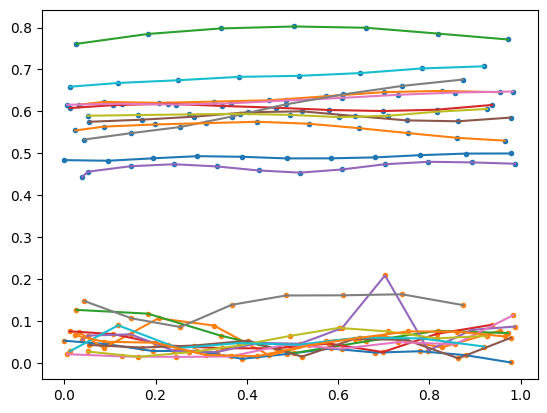

In [13]:

plt.scatter(startingEditedDf["displacementY"], startingEditedDf["speed"], marker = ".")


        
uniqueTrackId_collection = {} 

for pedId in allPedIds:
    uniqueTrackId_collection[pedId] = startingEditedDf[startingEditedDf["uniqueTrackId"] == pedId].copy()
    plt.plot(uniqueTrackId_collection[pedId]["displacementY"], uniqueTrackId_collection[pedId]["speed"])
# plt.show()
plt.scatter(startingEditedDf["displacementY"], startingEditedDf["acceleration"], marker = ".")
for pedId in allPedIds:
    uniqueTrackId_collection[pedId] = startingEditedDf[startingEditedDf["uniqueTrackId"] == pedId].copy()
    plt.plot(uniqueTrackId_collection[pedId]["displacementY"], uniqueTrackId_collection[pedId]["acceleration"])
# plt.show()

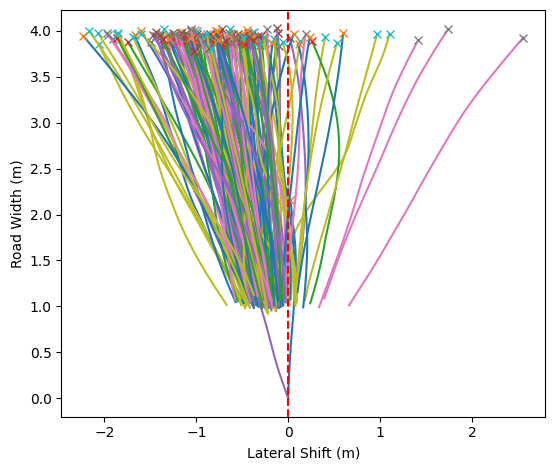

In [14]:
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
visualizer.show(midDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

{'whiskers': [<matplotlib.lines.Line2D at 0x1e65f6d13d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1e65f6d17f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e65f6c6c40>],
 'medians': [<matplotlib.lines.Line2D at 0x1e65f6da250>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e65f6daf40>],
 'means': []}

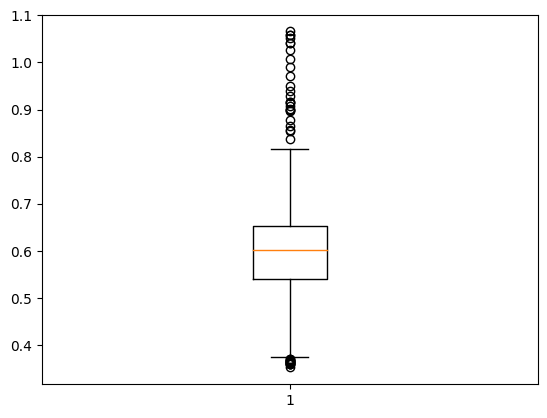

In [15]:
plt.boxplot(startingDf["speed"])

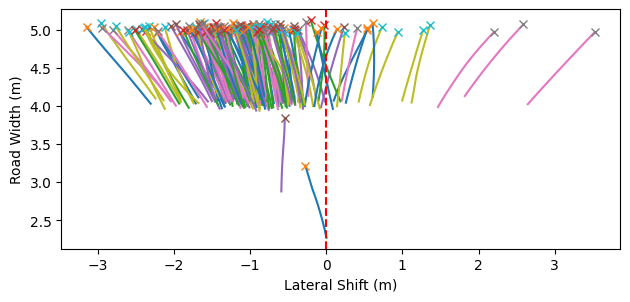

In [15]:
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()
visualizer.show(endDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

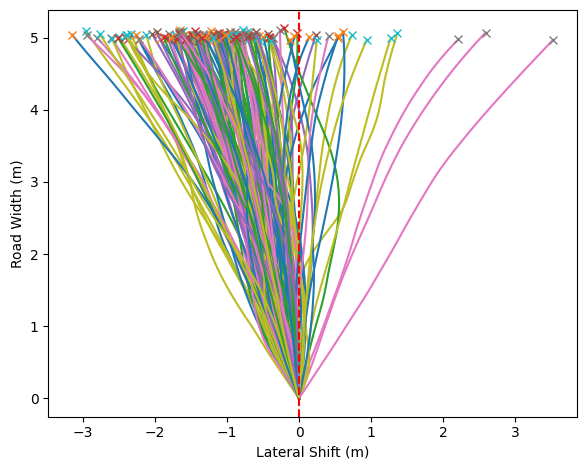

In [16]:

visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

{'whiskers': [<matplotlib.lines.Line2D at 0x28201988d00>,
 'caps': [<matplotlib.lines.Line2D at 0x2820198f280>,
 'boxes': [<matplotlib.lines.Line2D at 0x28201988b80>],
 'medians': [<matplotlib.lines.Line2D at 0x2820198f7c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2820198fa60>],
 'means': []}

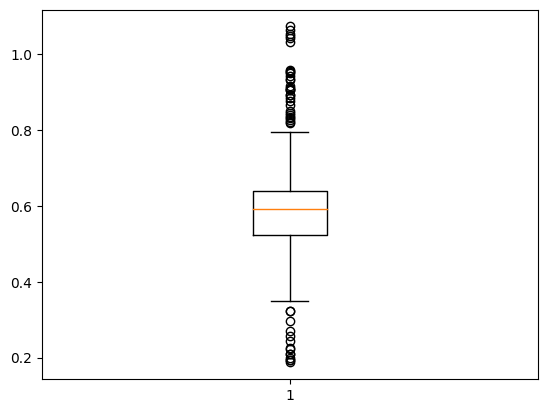

In [17]:
plt.boxplot(endDf["speed"])

<AxesSubplot: xlabel='speed', ylabel='Count'>

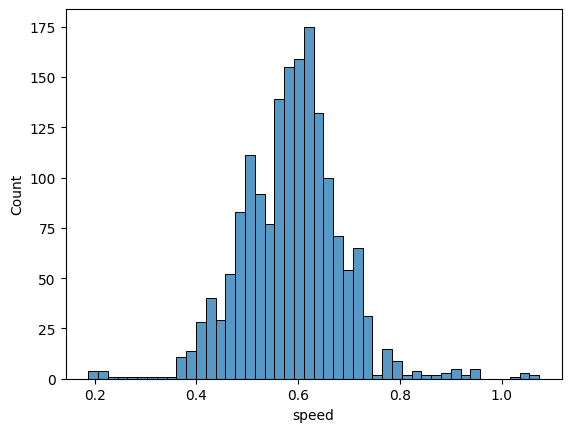

In [18]:
sns.histplot(endDf["speed"])

In [19]:
trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"]==18023]
ade = adeCalculator.getADE(trackDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
ade

0.30499600204316435

In [20]:
aade = adeCalculator.getADE(startingDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
aade

0.11068589901994656

In [21]:
sampler = Sampler()
sampleDf = sampler.getRandom(startingDf, idCol = 'uniqueTrackId', n=10)
aade = adeCalculator.getADE(sampleDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
aade

0.11100884694048807

<AxesSubplot: >

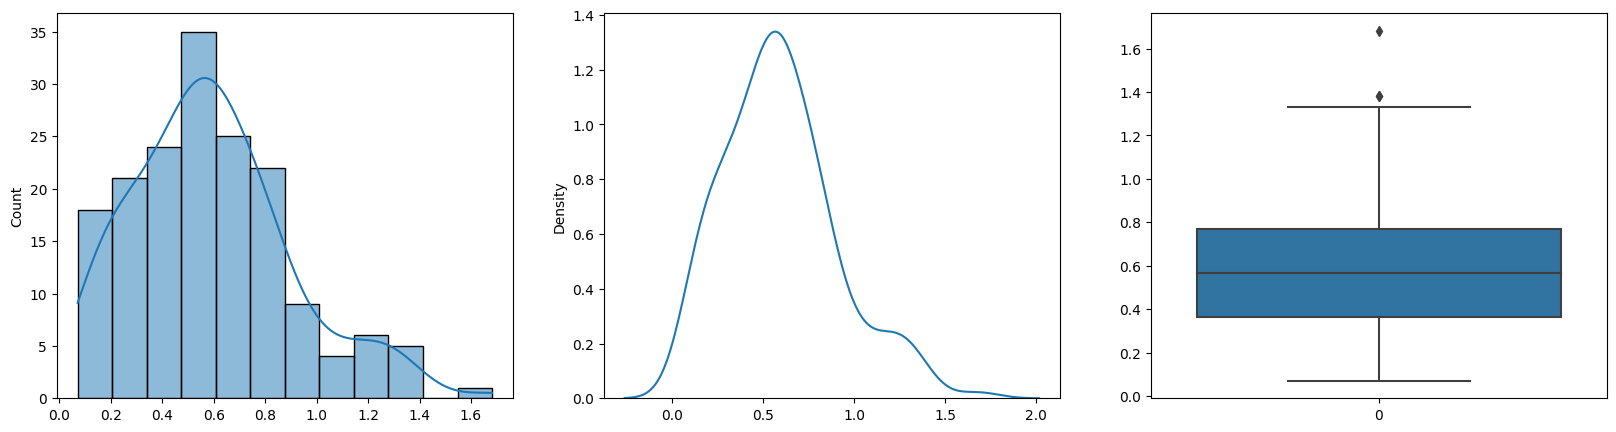

In [22]:
ades = adeCalculator.getADEs(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
sns.histplot(ades, kde='true', ax=axs[0])
sns.kdeplot(ades, ax=axs[1])
sns.boxplot(ades, ax=axs[2])

<AxesSubplot: >

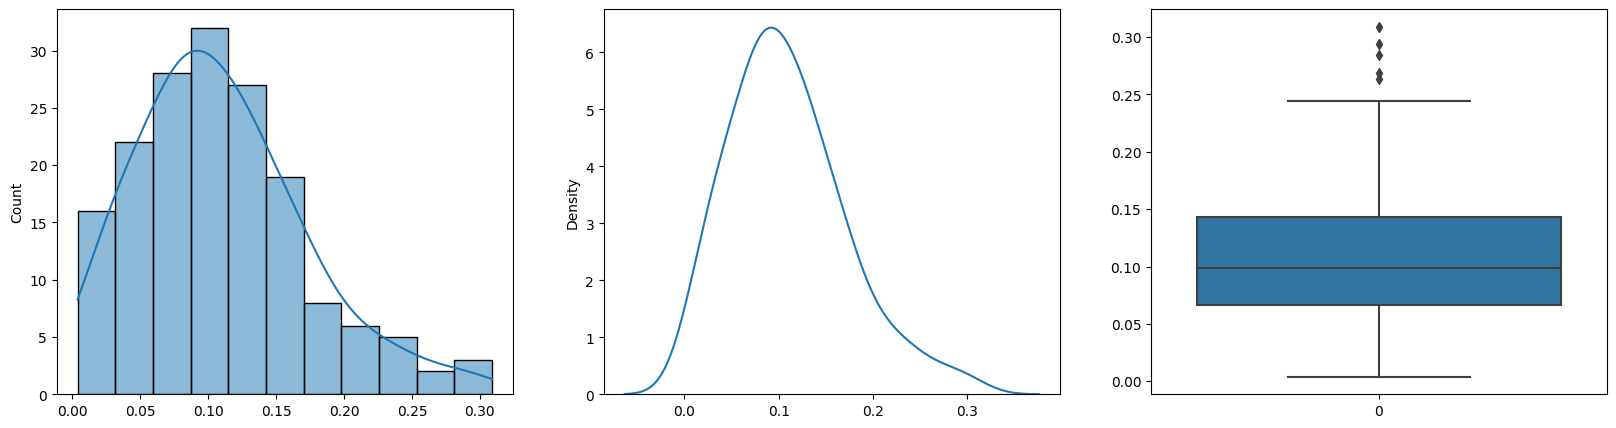

In [23]:
ades = adeCalculator.getADEs(startingDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')


fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
sns.histplot(ades, kde='true', ax=axs[0])
sns.kdeplot(ades, ax=axs[1])
sns.boxplot(ades, ax=axs[2])

<AxesSubplot: >

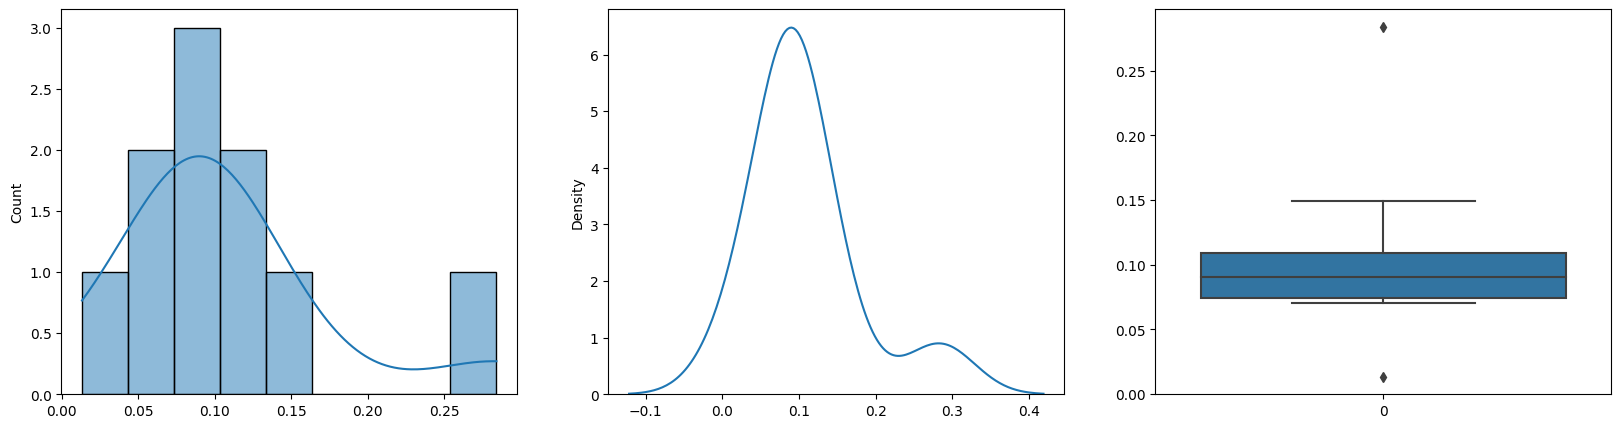

In [24]:
ades = adeCalculator.getADEs(sampleDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
sns.histplot(ades, kde='true', ax=axs[0])
sns.kdeplot(ades, ax=axs[1])
sns.boxplot(ades, ax=axs[2])

<AxesSubplot: >

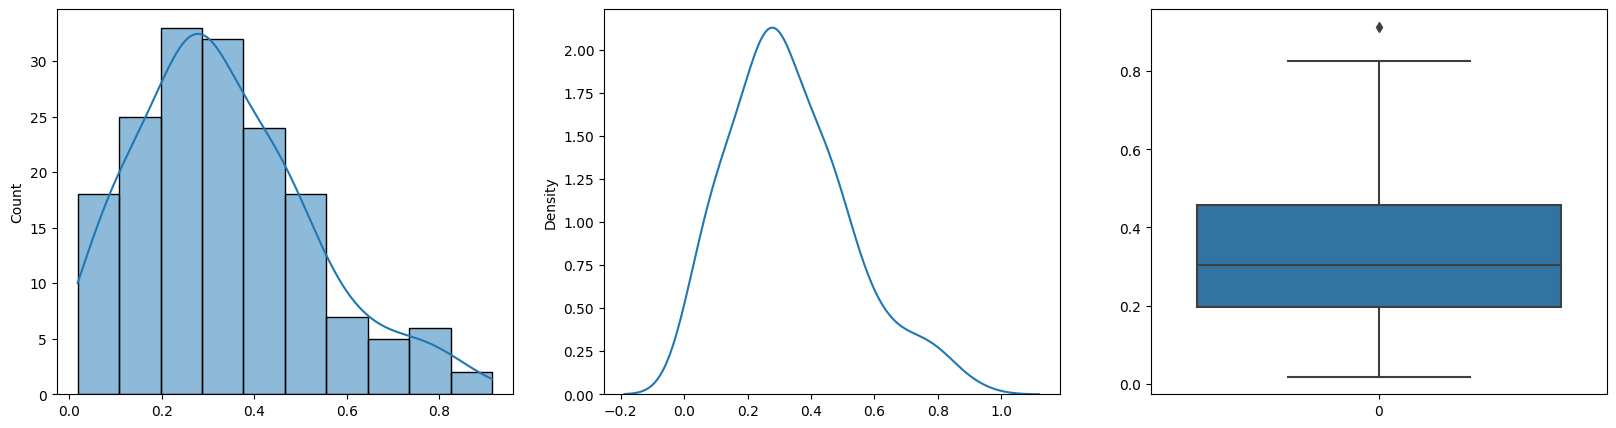

In [25]:
ades = adeCalculator.getADEs(midDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')


fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
sns.histplot(ades, kde='true', ax=axs[0])
sns.kdeplot(ades, ax=axs[1])
sns.boxplot(ades, ax=axs[2])

<AxesSubplot: >

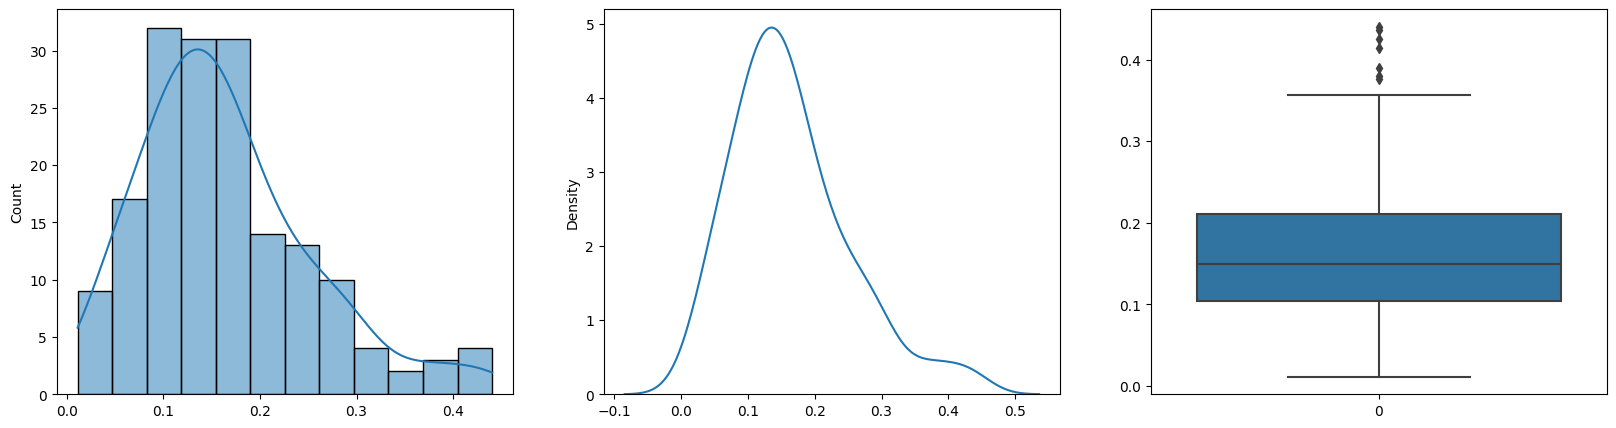

In [26]:
ades = adeCalculator.getADEs(endDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
sns.histplot(ades, kde='true', ax=axs[0])
sns.kdeplot(ades, ax=axs[1])
sns.boxplot(ades, ax=axs[2])

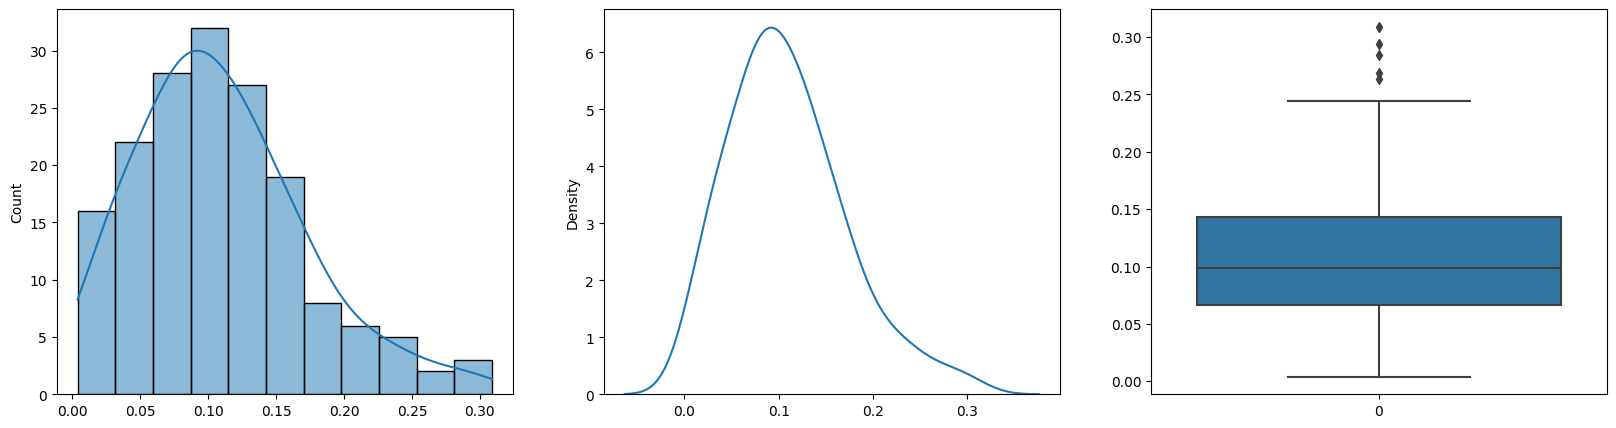

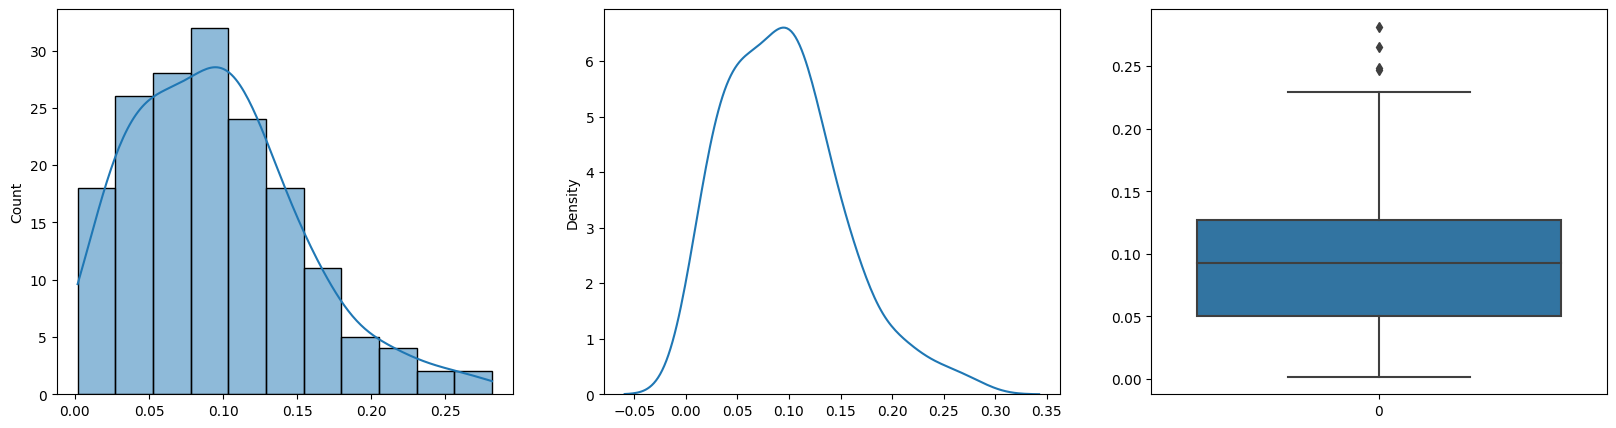

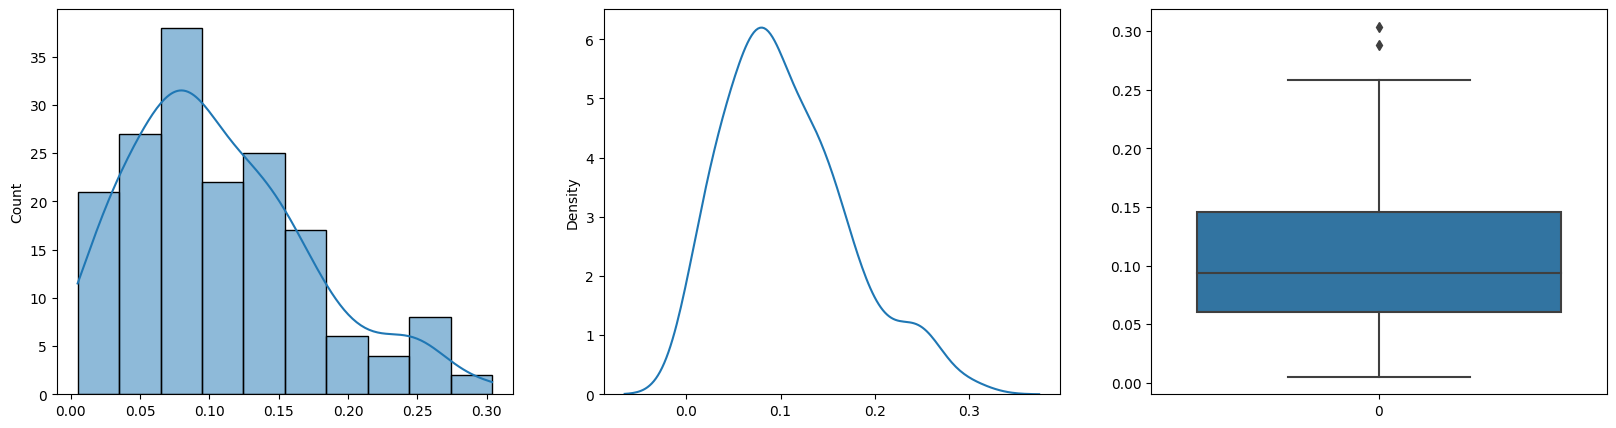

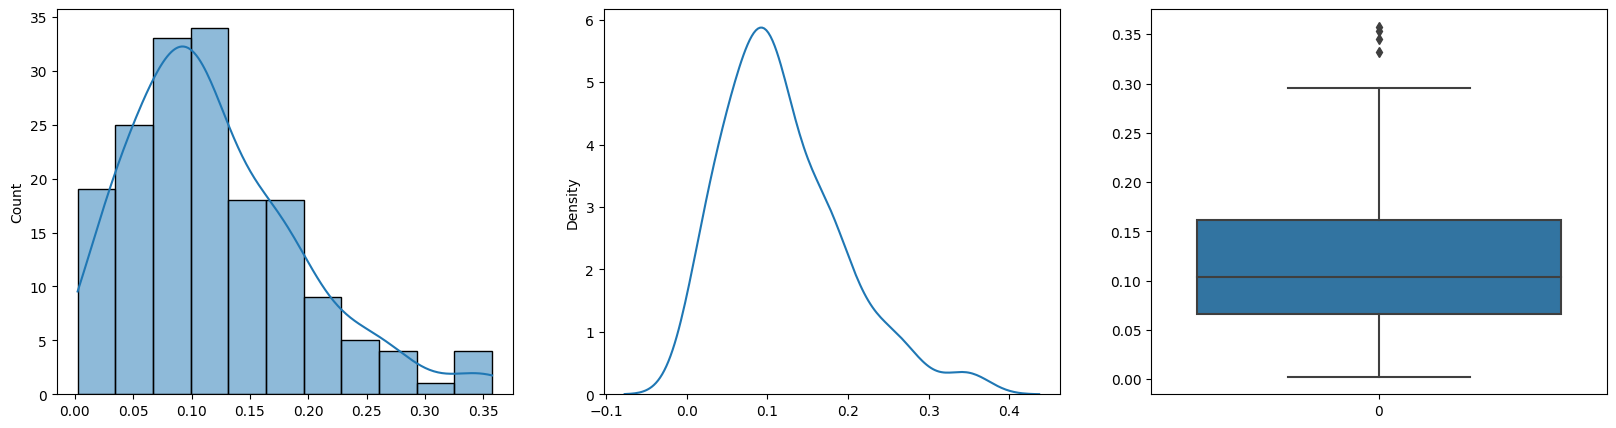

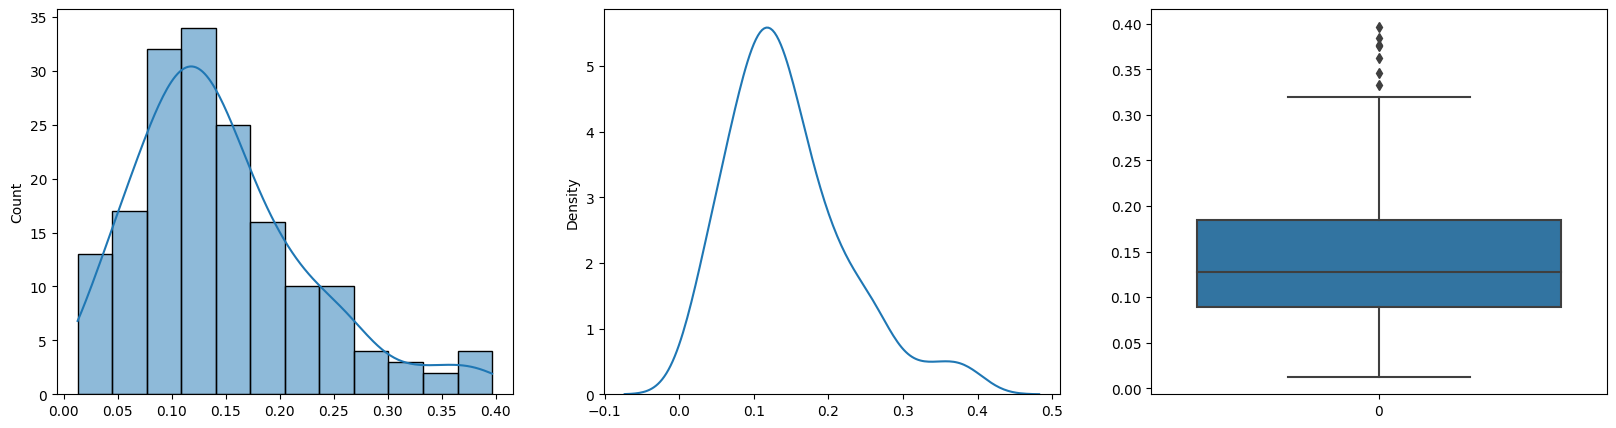

In [27]:
prevD = 0
for d in range(1, 6):
    tracksDf = cleanPedDf[(cleanPedDf["displacementY"] >= prevD) & (cleanPedDf["displacementY"] < d)].copy()
    prevD = d
    ades = adeCalculator.getADEs(tracksDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
    fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
    sns.histplot(ades, kde='true', ax=axs[0])
    sns.kdeplot(ades, ax=axs[1])
    sns.boxplot(ades, ax=axs[2])

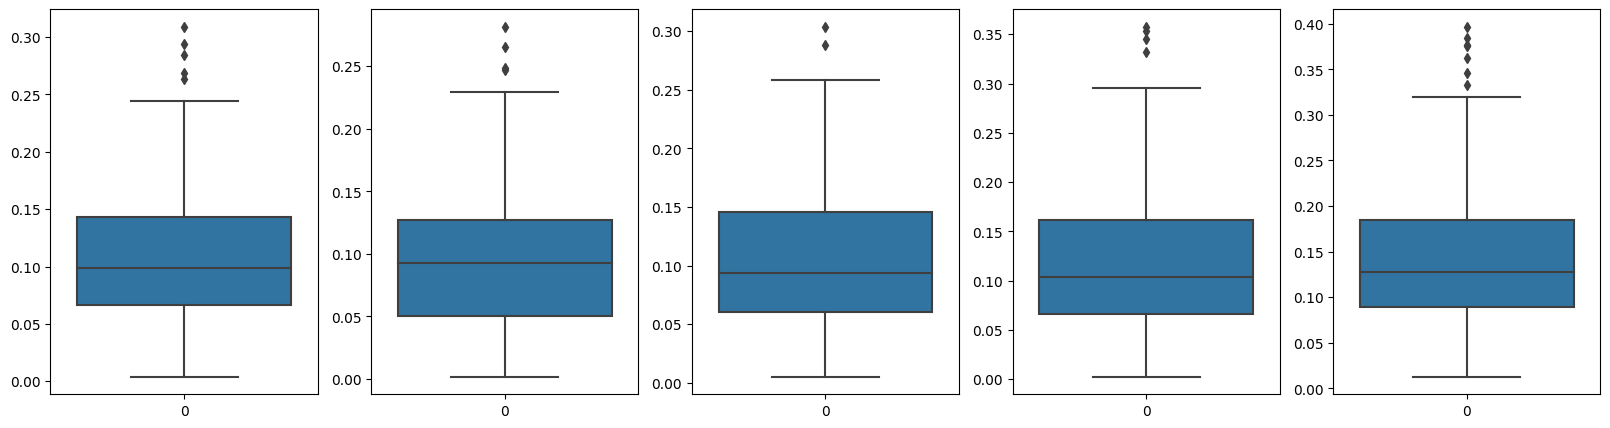

In [28]:
prevD = 0

fig, axs = plt.subplots(ncols=5, figsize=(20, 5))
for d in range(1, 6):
    tracksDf = cleanPedDf[(cleanPedDf["displacementY"] >= prevD) & (cleanPedDf["displacementY"] < d)].copy()
    prevD = d
    ades = adeCalculator.getADEs(tracksDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
    sns.boxplot(ades, ax=axs[d-1])

In [29]:
prevD = 0
aades = []
for d in range(1, 6):
    tracksDf = cleanPedDf[(cleanPedDf["displacementY"] >= prevD) & (cleanPedDf["displacementY"] < d)].copy()
    prevD = d
    aades.append(adeCalculator.getAADE(tracksDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY'))
    
print(aades)
# sns.barplot(aades)

[0.10923912159320787, 0.0950322179301514, 0.10635226529293768, 0.1186812554248694, 0.14475771067098828]


In [30]:
import scipy.stats as stats
alpha = 0.05

In [31]:
def findAlphaTAndPToRejectLE(popMean, samples, start=0.0):
    if np.mean(samples) > popMean:
        raise Exception(f"pop mean {popMean} cannot be less than sample mean {np.mean(samples)}") 
    alpha = start
    rejected = False

    t_statistic, p_value = testingCalculator.getTstatistic_pValue_adeslist(samples,popMean)
    increment = 0.00001
    for i in range(100000):
        if p_value / 2 < alpha:
            return alpha, t_statistic, p_value
        alpha += increment
    
    return None, None, None


def findAlphaTAndPToAcceptLE(popMean, samples, start=0.05): 
    if np.mean(samples) > popMean:
        raise Exception(f"pop mean {popMean} cannot be less than sample mean {np.mean(samples)}") 
    alpha = start
    accepted = False

    t_statistic, p_value = testingCalculator.getTstatistic_pValue_adeslist(samples,popMean)
    decrement = 0.00001
    for i in range(100000):
        if p_value / 2 > alpha:
            accepted = True
            break
        alpha -= decrement
    
    if not accepted:
        return None, None, None
    return max(alpha, 0), t_statistic, p_value



def findAlphaTAndPToAcceptGE(popMean, samples, start=0.05): 
    if np.mean(samples) < popMean:
        raise Exception(f"pop mean {popMean} cannot be greater than sample mean {np.mean(samples)}") 
    alpha = start
    accepted = False

    t_statistic, p_value = testingCalculator.getTstatistic_pValue_adeslist(samples,popMean)
    decrement = 0.00001
    for i in range(100000):
        if p_value / 2 > alpha:
            accepted = True
            break
        alpha -= decrement
    
    if not accepted:
        return None, None, None
    # print(alpha)
    return max(alpha, 0), t_statistic, p_value
        
    

In [32]:
ades = adeCalculator.getADEs(startingDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
print("ades mean. testing >=pop mean in starting df", np.mean(ades))
for population_mean in [0.0, 0.1, 0.2, 0.3, 0.5]:
    try:
        alpha, t, p = findAlphaTAndPToAcceptGE(population_mean, ades)
        rejected = "accepted" if alpha is not None else "rejected"
        print(f"population_mean: {population_mean}, alpha: {alpha}, t {t}, p {p}, test: {rejected}")
    except Exception as e:
        print(e)

NameError: name 'np' is not defined

In [ ]:
ades = adeCalculator.getADEs(endDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
print("ades mean. testing >=pop mean in end df", np.mean(ades))
for population_mean in [0.0, 0.1, 0.15, 0.3, 0.5]:
    try:
        alpha, t, p = findAlphaTAndPToAcceptGE(population_mean, ades)
        rejected = "accepted" if alpha is not None else "rejected"
        print(f"population_mean: {population_mean}, alpha: {alpha}, t {t}, p {p}, test: {rejected}")
    except Exception as e:
        print(e)

In [ ]:
ades = adeCalculator.getADEs(midDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
print("ades mean. testing >=pop mean in mid df", np.mean(ades))
for population_mean in [0.0, 0.1, 0.15, 0.3, 0.5, 0.56, 0.6, 0.7, 1]:
    try:
        alpha, t, p = findAlphaTAndPToAcceptGE(population_mean, ades)
        rejected = "accepted" if alpha is not None else "rejected"
        print(f"population_mean: {population_mean}, alpha: {alpha}, t {t}, p {p}, test: {rejected}")
    except Exception as e:
        print(e)

In [ ]:
ades = adeCalculator.getADEs(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
print("ades mean. testing >=pop mean in whole df", np.mean(ades))
for population_mean in [0.0, 0.1, 0.15, 0.3, 0.5, 0.56, 0.6, 0.7, 1]:
    try:
        alpha, t, p = findAlphaTAndPToAcceptGE(population_mean, ades)
        rejected = "accepted" if alpha is not None else "rejected"
        print(f"population_mean: {population_mean}, alpha: {alpha}, t {t}, p {p}, test: {rejected}")
    except Exception as e:
        print(e)

In [ ]:
ades = adeCalculator.getADEs(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
print("ades mean testing <= pop mean whole df", np.mean(ades))
for population_mean in [0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 1]:
    try:
        alpha, t, p = findAlphaTAndPToAcceptLE(population_mean, ades)
        rejected = "accepted" if alpha is not None else "rejected"
        print(f"population_mean: {population_mean}, alpha: {alpha}, t {t}, p {p}, test: {rejected}")
    except Exception as e:
        print(e)

In [ ]:
ades = adeCalculator.getADEs(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
print("ades mean testing <= pop mean", np.mean(ades))
for population_mean in [0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 1]:
    try:
        alpha, t, p = findAlphaTAndPToRejectLE(population_mean, ades)
        rejected = "rejected" if alpha is not None else "accepted"
        print(f"population_mean: {population_mean}, alpha: {alpha}, t {t}, p {p}, test: {rejected}")
    except Exception as e:
        print(e)